# Finding Nearest Neighbour to an image from VAE

Write down proper formulation of the CVAE in terms of stats/variational inference

"find the optimal zy which maximizes the lower bound on the log-likelihood for each class:"

Why do we weight KL divergence and the reconstruction error equally?

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Nicer way to import the module?
sys.path.append(str(Path.cwd().parent))
from utils.loading import load_net
from utils.data import make_generators_DF_cifar
from utils.display import torch_to_np
from utils.train_val_auto import AverageMeter

import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torch.nn import functional as F
import torch.optim as optim

import foolbox
import json
from PIL import Image

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.current_device())

cuda:1
0


In [2]:
model_loc = '/media/rene/data/adv_consistency/MNIST/mnist_normal/models/CVAE-1_16_32_64-16-MNIST-10_model_best.pth.tar'
model = load_net(model_loc).to(device).eval()

files_df_loc = '/media/rene/data/adv_consistency/MNIST/mnist_normal/files_df.pkl'

with open(files_df_loc, 'rb') as f:
    files_df = pickle.load(f)

In [3]:
def show_imgs(imgs, labels, cols = 3):
    if not isinstance(imgs, np.ndarray):#convert torch to numpy
        imgs = torch_to_np(imgs)
        imgs = np.moveaxis(imgs, 0, -1)
        
    if not isinstance(labels, np.ndarray):#convert torch to numpy
        labels = torch_to_np(labels)
        labels = np.moveaxis(labels, 0, -1)

    n_imgs = imgs.shape[0]
    fig = plt.figure()
    for i in range(n_imgs):
        ax = fig.add_subplot(cols, np.ceil(n_imgs/float(cols)), i + 1)
        img = np.squeeze(imgs[i, :, :])
        label = np.squeeze(labels[i])
        plt.gray()
        plt.imshow(img)
        plt.axis('off')
        ax.set_title(label, fontsize=40)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_imgs)
    fig.tight_layout()
    plt.show()

## Sampling from the latent space conditioned on different classes

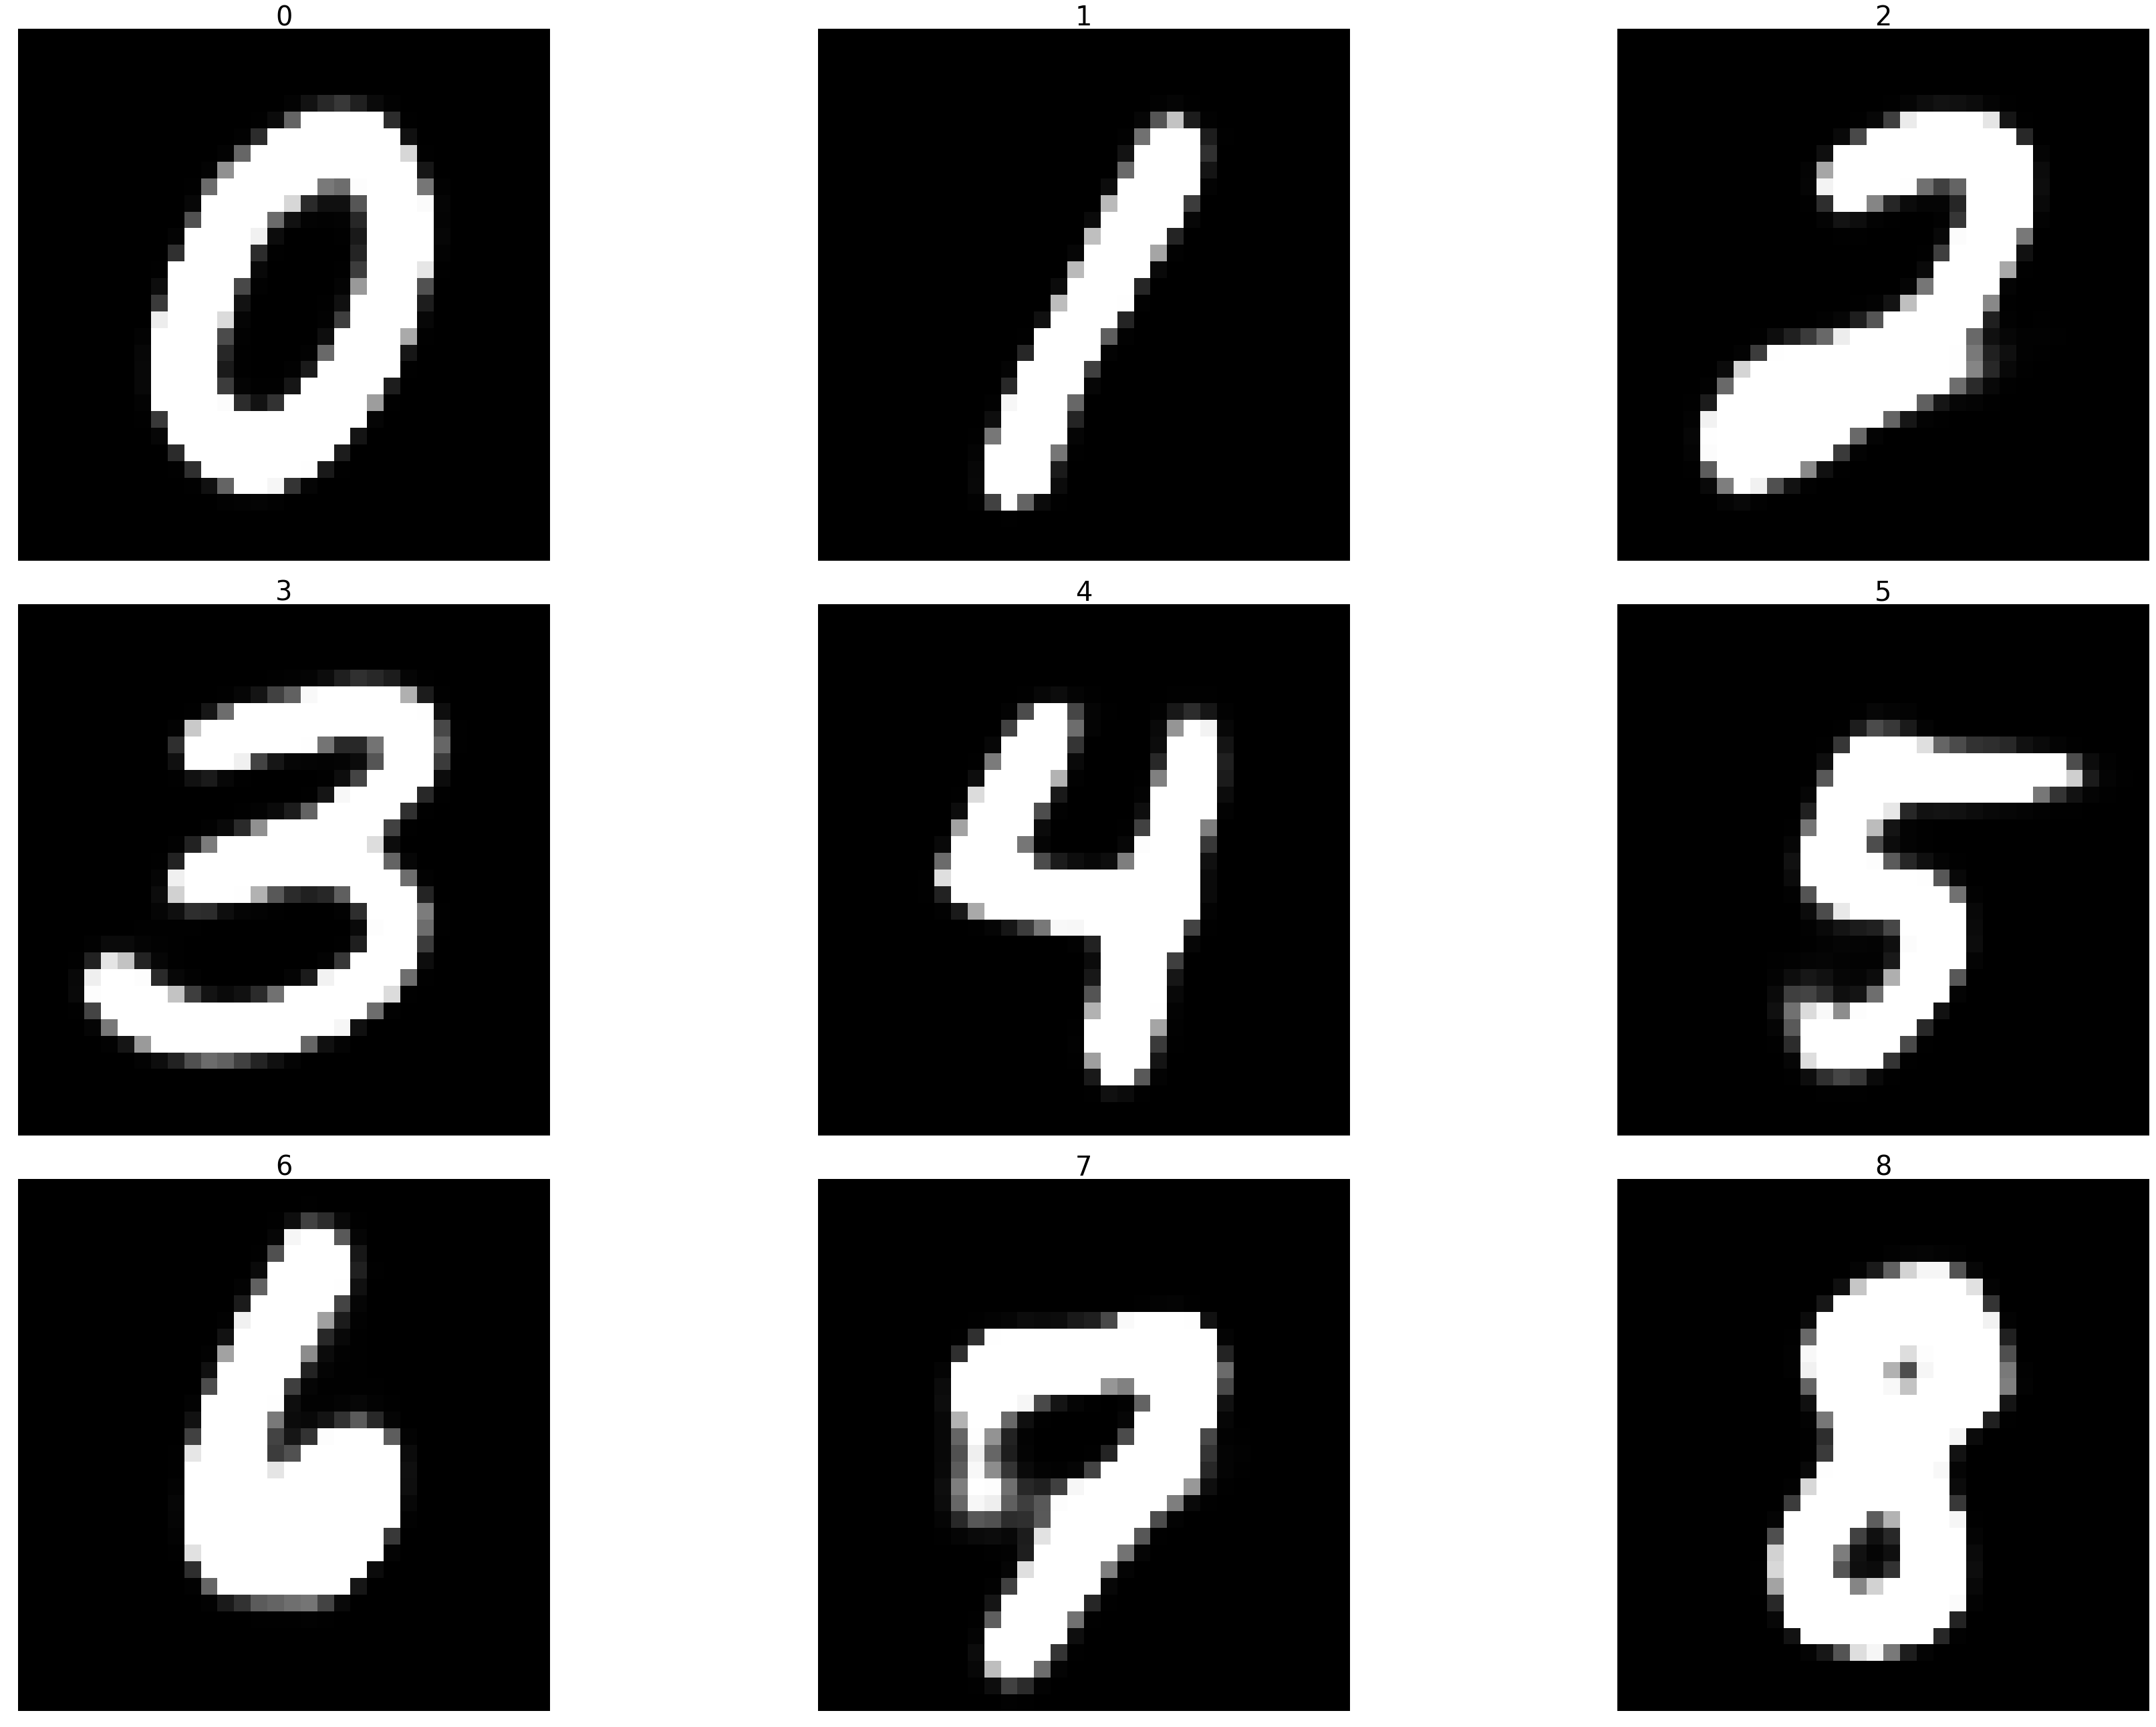

In [6]:
with torch.cuda.device(1):
    num = 9
    randn = np.random.normal(0,1, (num, 16))
    random_latent = torch.from_numpy(randn).type(torch.FloatTensor).to(device)
    labels = torch.from_numpy(np.array(list(range(num)))).type(torch.LongTensor).to(device)
    imgs = torch_to_np(model.decode(random_latent, labels))
    labels = torch_to_np(labels)
    show_imgs(imgs, labels, cols = 3)

## Reconstructing one image with different classes
* Clearly easier to reconstruct using the correct class

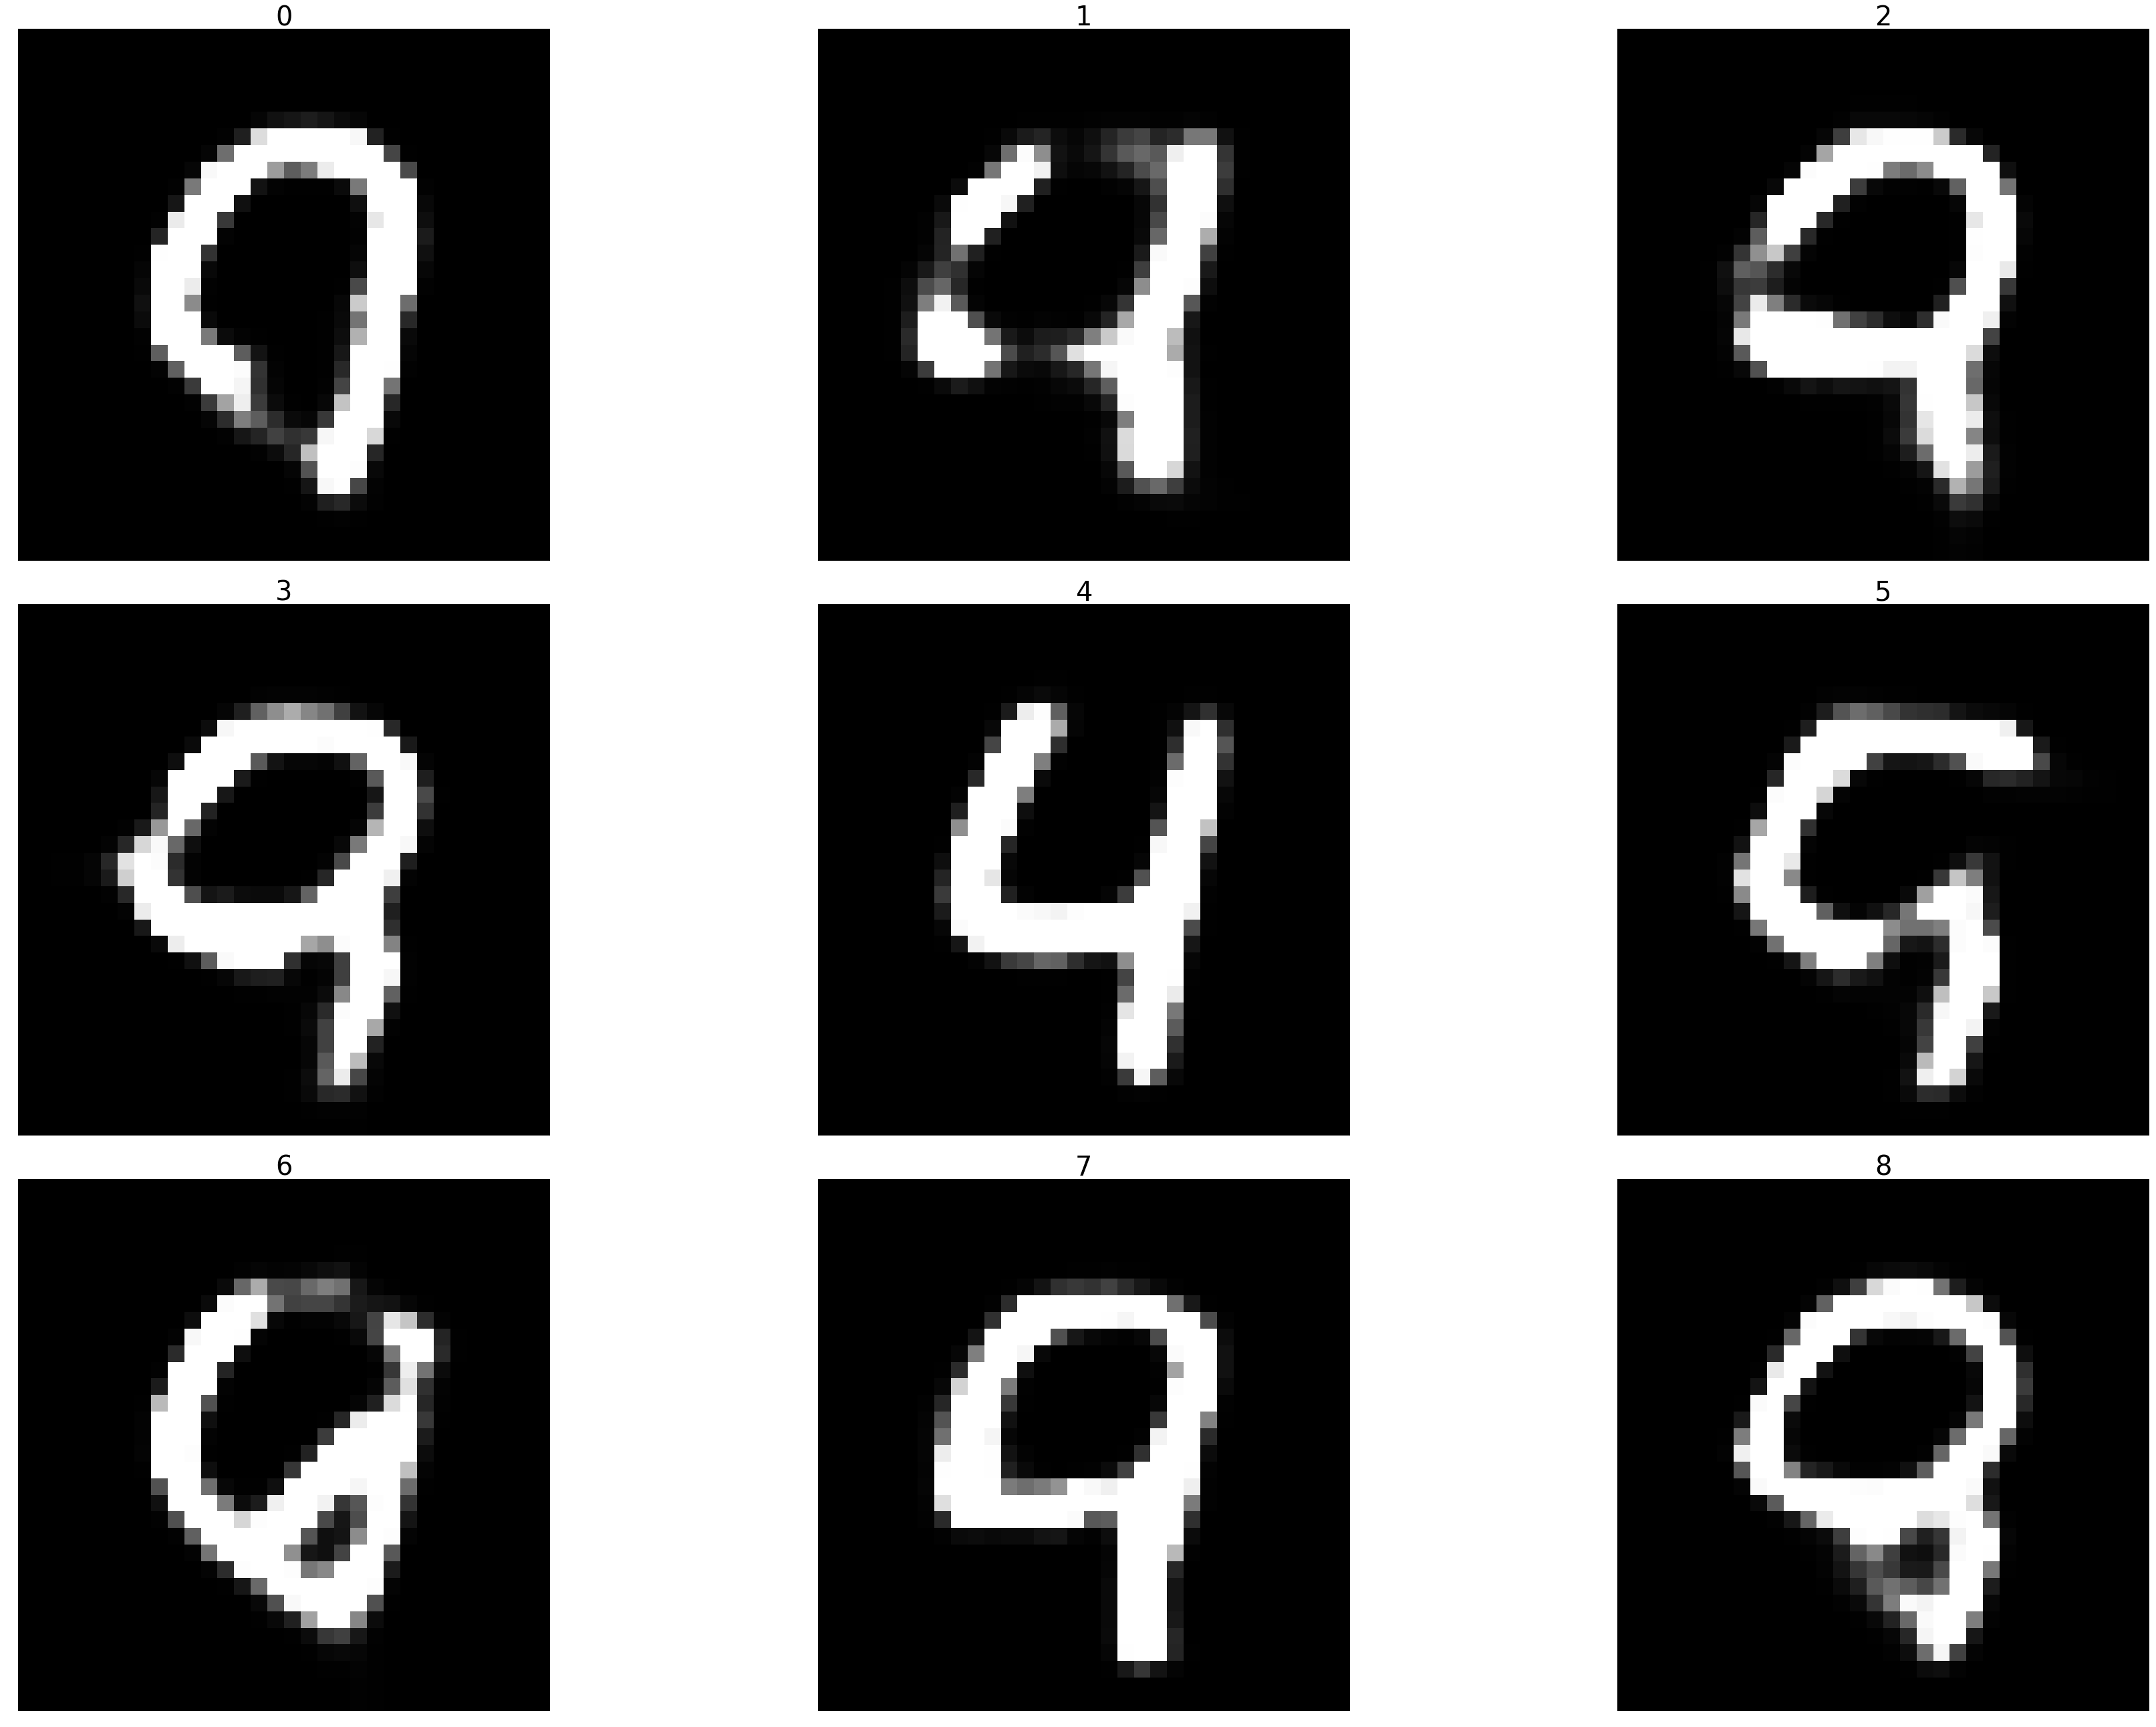

In [5]:
with torch.cuda.device(1):
    img_path = files_df['val'].iloc[4]['path']
    transform = transforms.Compose([
                                    transforms.Resize(32),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])
    
    num = 9
    tensor_labels = torch.from_numpy(np.array(list(range(num)))).type(torch.LongTensor).to(device)
    tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)
    tensor_imgs = tensor_img.repeat(num, 1, 1, 1)


    recon_x, mu, logvar = model(tensor_imgs, tensor_labels)      

    recon_x = torch_to_np(recon_x)
    labels = torch_to_np(tensor_labels)

show_imgs(recon_x, labels, cols = 3)

## Reproducing an image by doing gradient descent in the latent space
* Minimize the L2 distance between an input image and the output of the generator by doing gradient descent on the latent variables
* *** Not the true loss, ignoring the KL divergence

In [17]:
def optimize_latent(imgs, labels, mu, logvar, model, lr=.001, iterations=50, only_BCE_loss=True):
    model=model.eval()
    mu.requires_grad = True
    logvar.requires_grad = True
    labels.requires_grad = False
    
    params = list(model.decoder.parameters()) + list(model.fc1.parameters())
    optimizer = optim.Adam(params, lr=lr)
    
    if only_BCE_loss:
        criterion = F.mse_loss #(recon_x, img, size_average=False)
    else:
        criterion = model.loss

    for i in range(iterations):
        z = model.reparameterize(mu, logvar)
        recon_x = model.decode(z, labels)
        loss = criterion((recon_x, mu, logvar), imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return recon_x, z, loss

In [48]:
num = 9
latent_size = 16
tensor_labels = torch.from_numpy(np.array(list(range(num)))).type(torch.LongTensor).to(device)
# init_z = np.random.normal(0,1, (num, latent_size))
# init_z = torch.from_numpy(init_z).type(torch.FloatTensor).to(device)
mu = np.random.normal(0,1, (num, latent_size))
mu = torch.from_numpy(mu).type(torch.FloatTensor).to(device)
logvar = np.random.normal(0,1, (num, latent_size))
logvar = torch.from_numpy(logvar).type(torch.FloatTensor).to(device)

img_path = files_df['val'].iloc[4]['path']
img_label = files_df['val'].iloc[4]['class']

transform = transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)
tensor_imgs = tensor_img.repeat(num, 1, 1, 1)

img_label 4.0


/media/rene/ADV/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


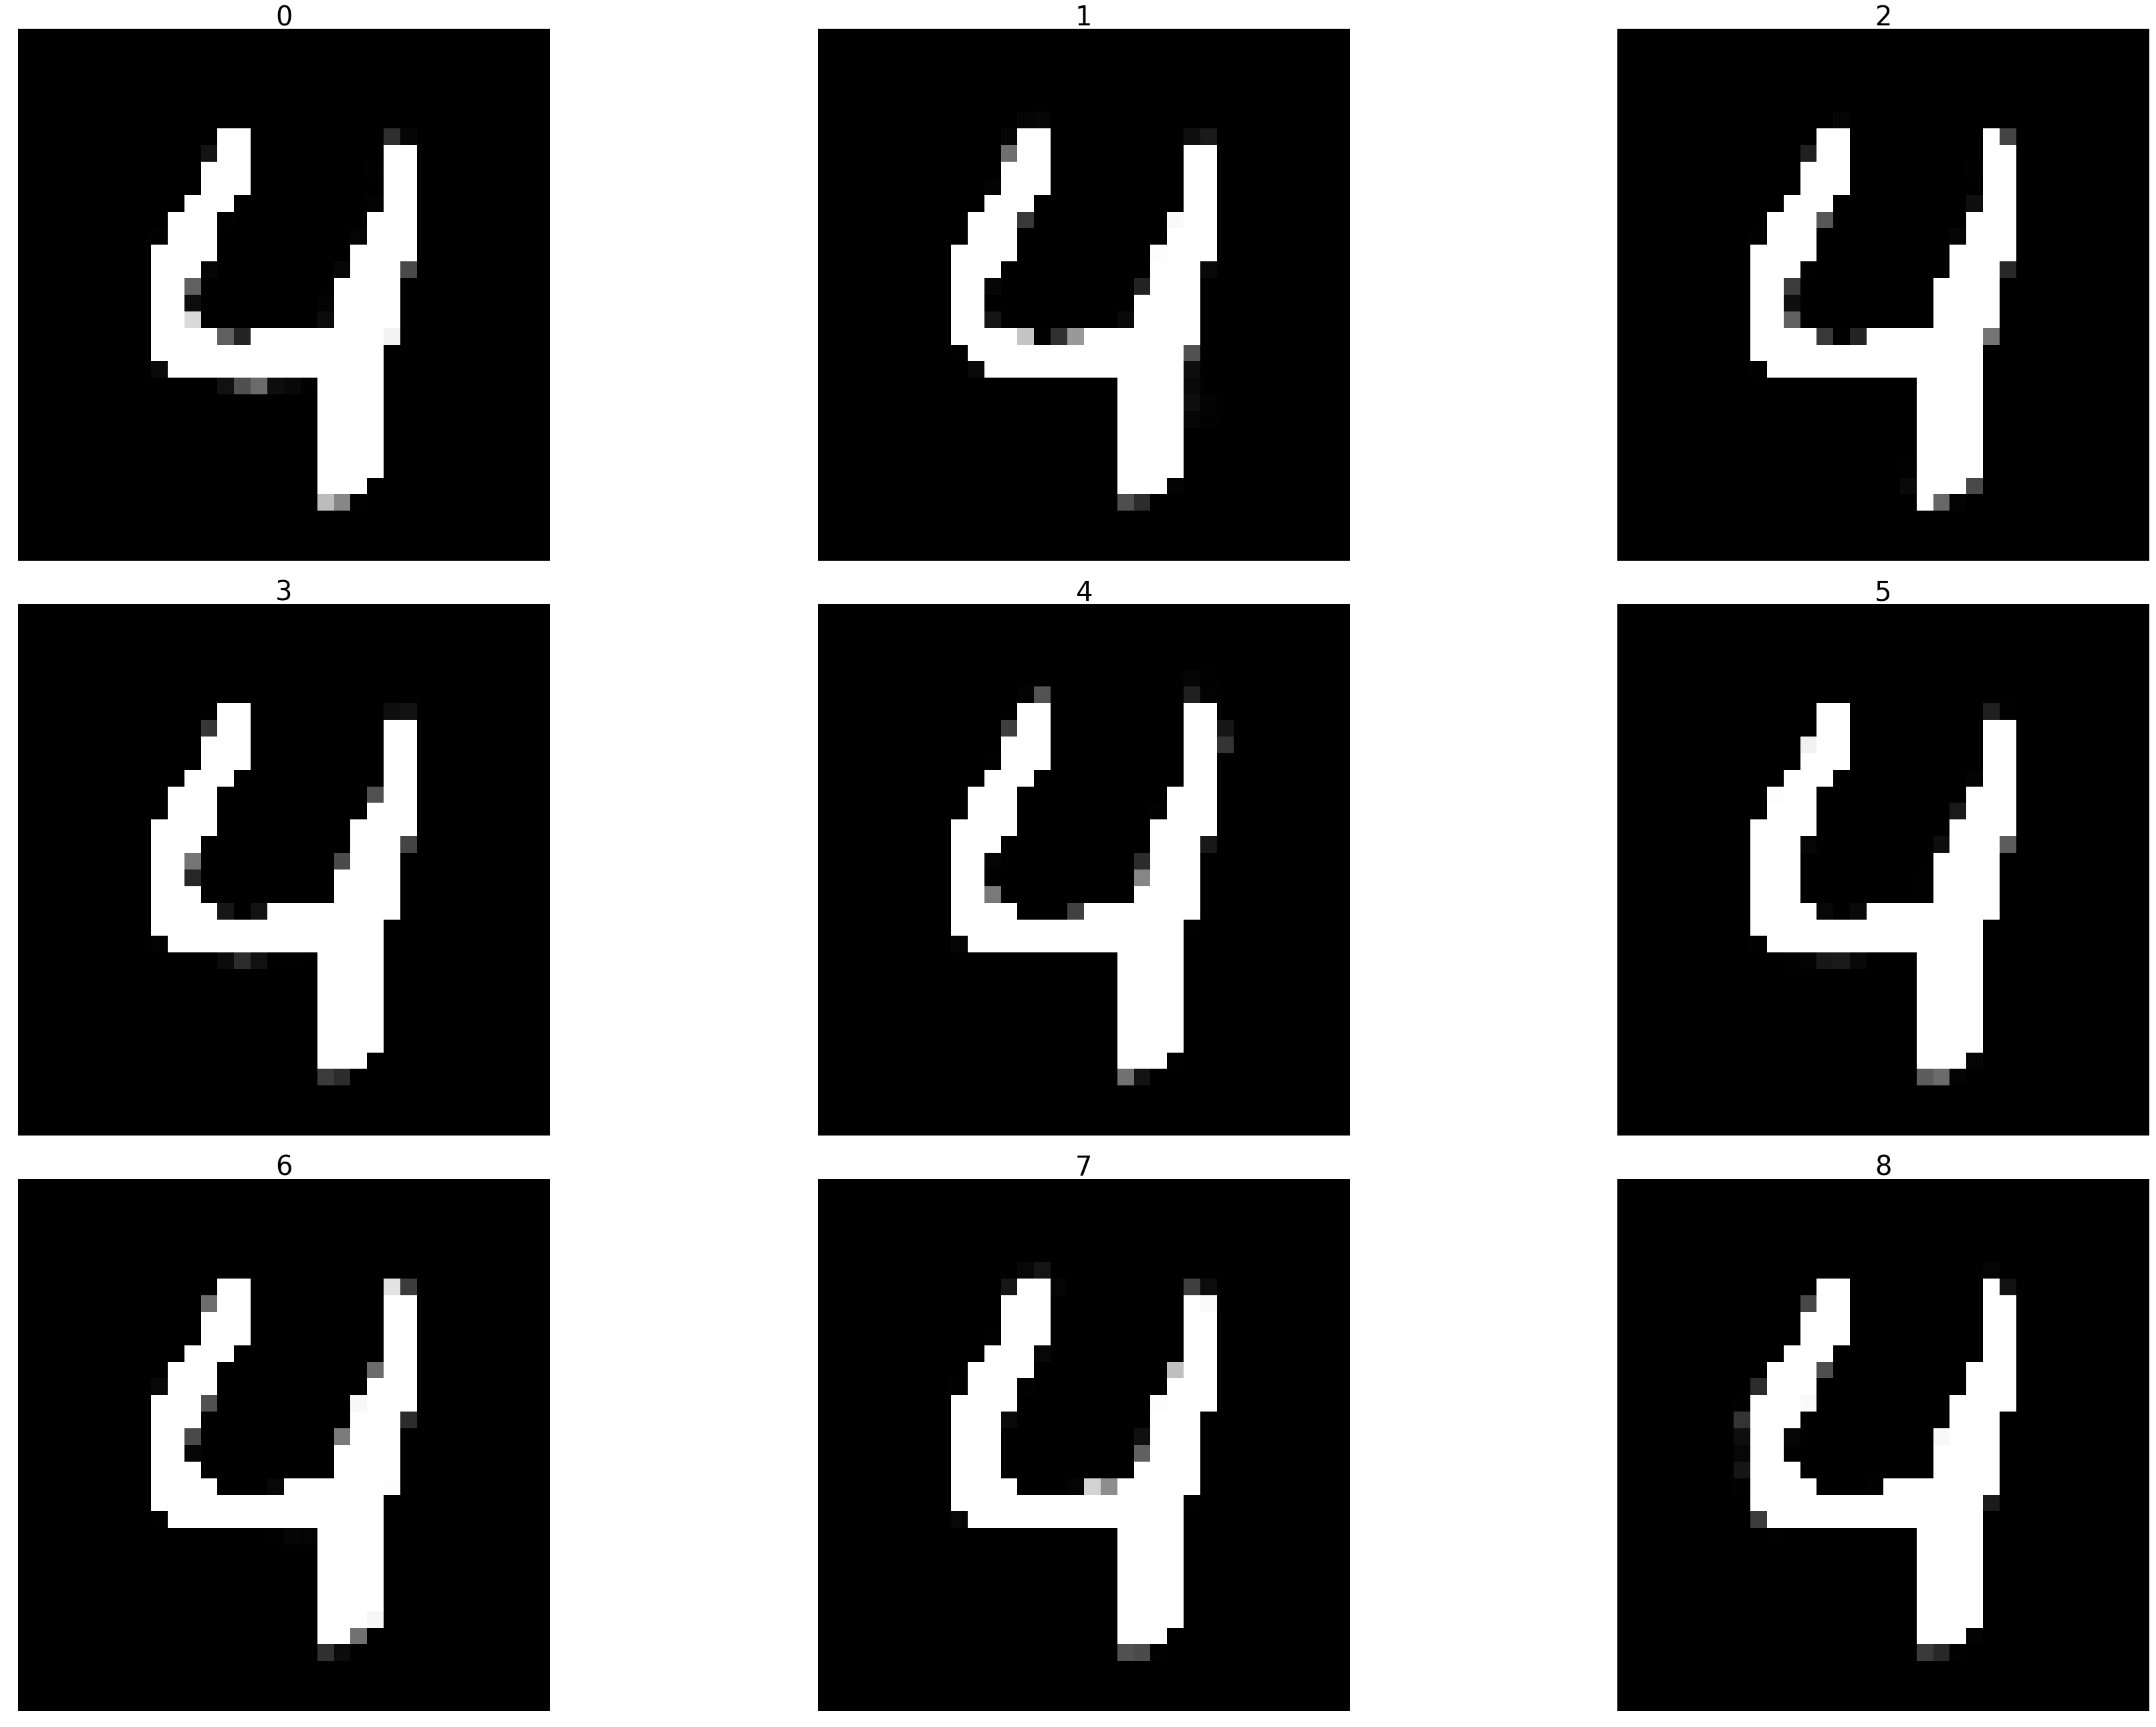

In [50]:
print('img_label', img_label)
with torch.cuda.device(1):
    all_recon = []
    for i in range(num):
        img = tensor_imgs[i, :, :, :].unsqueeze(0)
        label = tensor_labels[i].unsqueeze(0)
        mu_i = Variable(mu[i, :].unsqueeze(0))
        logvar_i = Variable(logvar[i, :].unsqueeze(0))

        recon_x, z, loss = optimize_latent(img, label, mu_i, logvar_i, model, iterations=10, only_BCE_loss=False)
        
        all_recon.append(torch_to_np(recon_x))
show_imgs(np.array(all_recon), tensor_labels, cols = 3)

## Find the class with minimum reconstruction error
* Random initializations of the latent vectors, perform sgd to reconstruct the input image by minimizing BCE+KL
* Do this for many random initializations for each class, then take the best reconstruction as the classification


Questions
* Why is the error 50% KL and reconstruction?
* Should we be using the sampling, or just use a fized z (like using mu with var=0)
* **Optimizing**: Could initialize the search with the latent encoding of each one in each autoencoder

In [20]:
num_labels = 10
latent_size = 16
num_times = 100

tensor_labels = torch.from_numpy(np.array(list(range(num_labels)))).type(torch.LongTensor).to(device)

def generative_classify(img, num_times, num_labels, latent_size, device):
    results = {}
    for i in range(num_labels):
        results[i] = []

    for trial in range(num_times):
        for label in range(num_labels):
            mu = np.random.normal(0,1, (1, latent_size))
            logvar = np.random.normal(0,1, (1, latent_size))
            mu = torch.from_numpy(mu).type(torch.FloatTensor).to(device)
            logvar = torch.from_numpy(logvar).type(torch.FloatTensor).to(device)

            tensor_label = torch.from_numpy(np.array(label)).unsqueeze(0).to(device)

            recon_x, z, loss = optimize_latent(img, tensor_label, mu, logvar, model, iterations=10, only_BCE_loss=False)

            results[label].append(loss.item())
    return results

In [21]:
img_path = files_df['val'].iloc[4]['path']
img_label = files_df['val'].iloc[4]['class']
transform = transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)

with torch.cuda.device(1):
    results = generative_classify(tensor_img, num_times=100, num_labels=10, latent_size=16, device=device)

/media/rene/ADV/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [23]:
for label, all_loss in results.items():
    print(f'label: {label}, min loss {np.min(all_loss)}, mean loss {np.mean(all_loss)}')

label: 0, min loss 316.8876647949219, mean loss 394.34635070800783
label: 1, min loss 312.1246032714844, mean loss 414.0178668212891
label: 2, min loss 316.88360595703125, mean loss 402.9967050170898
label: 3, min loss 312.53863525390625, mean loss 395.51374969482424
label: 4, min loss 315.1683349609375, mean loss 394.2249645996094
label: 5, min loss 317.8185119628906, mean loss 387.62901885986327
label: 6, min loss 318.2557373046875, mean loss 398.8324298095703
label: 7, min loss 313.05340576171875, mean loss 394.02329406738284
label: 8, min loss 316.2362365722656, mean loss 399.61161376953123
label: 9, min loss 311.8041687011719, mean loss 437.77677978515624
